In [83]:
from __future__ import print_function, division


import zipfile
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score

plt.ion()   # interactive mode

In [12]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),#обрезать изображение случайным образом
        transforms.ToTensor(),#преобразовывает ndarrays экземпляра в Tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './flowers'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
# специальный класс для загрузки данных в виде батчей
dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=4,
                                             shuffle=True, num_workers=4), 
               'valid': torch.utils.data.DataLoader(image_datasets[ 'valid'], batch_size=4,
                                             shuffle=True, num_workers=4),
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [89]:
# load test data
batch_size = 4
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
test_dir = os.path.join(data_dir,'test')
test_data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

test_dataset = datasets.ImageFolder(
    test_dir,
    test_data_transforms)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True,
    num_workers=4)

test_dataset_size =len(test_dataset)

test_names = test_dataset.classes

In [14]:
image_datasets_test=datasets.ImageFolder('./flowers', 'test')
print(image_datasets_test)

Dataset ImageFolder
    Number of datapoints: 12969
    Root location: ./flowers
    StandardTransform
Transform: 'test'


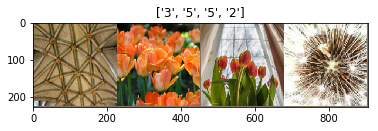

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [91]:
def evaluate(model):
    model.train(False)
    
    running_f1 = []
    running_precision = []
    running_recall = []
    running_correct = 0.0
    for data in  test_loader:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if gpu_mode:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, preds = torch.max(output, 1)
        
        running_correct += int(torch.sum(preds == labels))
        running_f1.append(metrics.f1_score(labels.data, preds.numpy(),average='micro'))
        running_precision.append(metrics.precision_score(labels.data, preds.numpy(),average='micro'))
        running_recall.append(metrics.recall_score(labels.data, preds.numpy(),average='micro'))
    
    
    print('Test F1: {:.4f} Precision: {:.4f} Recall: {:.4f}'.format(
                 np.mean(running_f1), np.mean(running_precision), np.mean(running_recall)))
    
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * (running_correct) / (test_dataset_size),
       (running_correct), (test_dataset_size)))
    
    return running_correct / len(test_dataset)

In [75]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, doc_train='doc_train.txt', doc_valid='doc_valid.txt'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    best_precision = 0.0
    best_recall = 0.0
    loss_in_epoch = {'train': [], 'valid':[]}
    corrects_in_epoch = {'train': [], 'valid':[]}
    f1_in_epoch = {'train': [], 'valid':[]}
    precision_in_epoch = {'train': [], 'valid':[]}
    recall_in_epoch = {'train': [], 'valid':[]}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
            running_f1 =[]
            running_precision = []
            running_recall = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_f1.append( f1_score(labels.data.numpy(),preds.numpy(),average='micro'))
                running_precision.append(precision_score(labels.data.numpy(), preds.numpy(),average='micro'))
                running_recall.append(recall_score(labels.data.numpy(), preds.numpy(),average='micro'))
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_f1 = np.mean(running_f1) 
            epoch_precision = np.mean(running_precision)
            epoch_recall = np.mean(running_recall)
            epoch__corrects=running_corrects / dataset_sizes[phase]


            print('{} F1: {:.4f} Precision: {:.4f} Recall: {:.4f}'.format(
                phase, epoch_f1, epoch_precision, epoch_recall))
            
            loss_in_epoch[phase].append(epoch_loss)
            corrects_in_epoch[phase].append(epoch__corrects)
            f1_in_epoch[phase].append(epoch_f1)
            precision_in_epoch[phase].append(epoch_precision)
            recall_in_epoch[phase].append(epoch_recall)

            # deep copy the model
            # deep copy the model
            if phase == 'valid' and epoch_f1 > best_f1:
                best_f1= epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val F1: {:4f}'.format(best_f1))
    plt.figure(figsize=(20, 15))
    plt.subplot(3,2,1)
    plt.plot(np.arange(len(loss_in_epoch[phase])),loss_in_epoch[phase])
    plt.xlabel('number epoch')
    plt.ylabel('loss')

    plt.subplot(3,2,2)
    plt.plot(np.arange(len(corrects_in_epoch[phase])),corrects_in_epoch[phase])
    plt.xlabel('number epoch')
    plt.ylabel('corrects')

    plt.subplot(3,2,3)
    plt.plot(np.arange(len (f1_in_epoch[phase])), f1_in_epoch[phase])
    plt.xlabel('number epoch')
    plt.ylabel('f1')

    plt.subplot(3,2,4)
    plt.plot(np.arange(len (precision_in_epoch[phase])), precision_in_epoch[phase])
    plt.xlabel('number epoch')
    plt.ylabel('precision')

    plt.subplot(3,2,5)
    plt.plot(np.arange(len (recall_in_epoch[phase])), recall_in_epoch[phase])
    plt.xlabel('number epoch')
    plt.ylabel('recall')
    
    
    with open(doc_valid,'w') as doc_valid:
        for i in range(len(loss_in_epoch['valid'])):
            doc_valid.write(str(i)+'  ')
            doc_valid.write(str(loss_in_epoch['valid'][i])+'  ')
            doc_valid.write(str(corrects_in_epoch['valid'][i].item())+'  ')
            doc_valid.write(str(f1_in_epoch['valid'][i])+'  ')
            doc_valid.write(str(precision_in_epoch['valid'][i])+'  ')
            doc_valid.write(str(recall_in_epoch['valid'][i])+'\n')
    with open(doc_train,'w') as doc_train:
        for i in range(len(loss_in_epoch['train'])):
            doc_train.write(str(i)+'  ')
            doc_train.write(str(loss_in_epoch['train'][i])+'  ')
            doc_train.write(str(corrects_in_epoch['train'][i].item())+'  ')
            doc_train.write(str(f1_in_epoch['train'][i])+'  ')
            doc_train.write(str(precision_in_epoch['train'][i])+'  ')
            doc_train.write(str(recall_in_epoch['train'][i])+'\n')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [76]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} real: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Для vgg19

In [71]:
model_extractor = models.vgg19(pretrained=True)

In [72]:
model_extractor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [77]:
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088

model_extractor.classifier =nn.Sequential(nn.Linear(in_features=25088, out_features=4096, bias=True), 
                                       nn.ReLU(inplace=True),
                                       nn.Dropout(p=0.5, inplace=False),
                                       nn.Linear(in_features=4096, out_features=4096, bias=True),
                                       nn.ReLU(inplace=True),
                                       nn.Dropout(p=0.5, inplace=False),
                                       nn.Linear(in_features=4096, out_features=5, bias=True),
                                       nn.LogSoftmax(dim=1))

#inputs = inputs.to(device)
#outputs = model_conv(inputs)

model_extractor =  model_extractor.to(device)

criterion =  nn.NLLLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam( model_extractor.classifier.parameters(), lr=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


Epoch 0/6
----------
train F1: 0.6329 Precision: 0.6329 Recall: 0.6329
valid F1: 0.7222 Precision: 0.7222 Recall: 0.7222

Epoch 1/6
----------
train F1: 0.6715 Precision: 0.6715 Recall: 0.6715
valid F1: 0.7391 Precision: 0.7391 Recall: 0.7391

Epoch 2/6
----------
train F1: 0.7016 Precision: 0.7016 Recall: 0.7016
valid F1: 0.7837 Precision: 0.7837 Recall: 0.7837

Epoch 3/6
----------
train F1: 0.7145 Precision: 0.7145 Recall: 0.7145
valid F1: 0.8081 Precision: 0.8081 Recall: 0.8081

Epoch 4/6
----------
train F1: 0.7351 Precision: 0.7351 Recall: 0.7351
valid F1: 0.8283 Precision: 0.8283 Recall: 0.8283

Epoch 5/6
----------
train F1: 0.7427 Precision: 0.7427 Recall: 0.7427
valid F1: 0.7803 Precision: 0.7803 Recall: 0.7803

Epoch 6/6
----------
train F1: 0.7340 Precision: 0.7340 Recall: 0.7340
valid F1: 0.8157 Precision: 0.8157 Recall: 0.8157

Training complete in 441m 9s
Best val F1: 0.828283


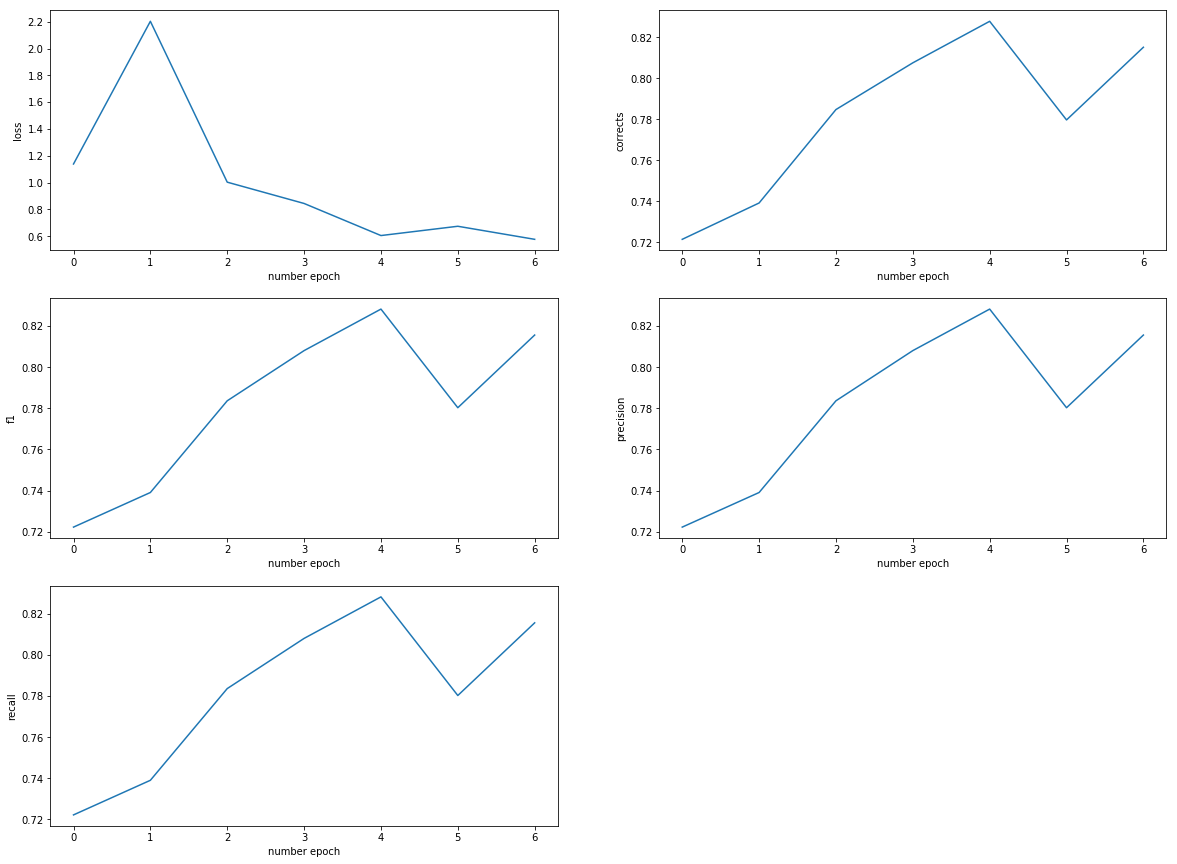

In [78]:
model_extractor = train_model(model_extractor, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=7,doc_train='vgg19_train.txt',doc_valid='vgg19_valid.txt')

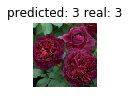

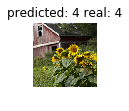

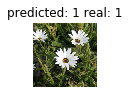

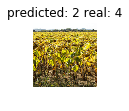

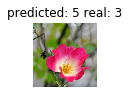

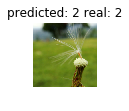

In [79]:
visualize_model(model_extractor)

plt.ioff()
plt.show()

In [92]:
acc=evaluate(model_extractor)

Test F1: 0.8271 Precision: 0.8271 Recall: 0.8271

Test Accuracy (Overall): 82% (311/376)


Смешанный сценарий обучения vgg19

In [85]:
model_mixed2=models.vgg19(pretrained=True)
layers_to_unfreeze = 3

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mixed2.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False


# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088

model_mixed2.classifier =nn.Sequential(nn.Linear(in_features=25088, out_features=4096, bias=True), 
                                       nn.ReLU(inplace=True),
                                       nn.Dropout(p=0.5, inplace=False),
                                       nn.Linear(in_features=4096, out_features=4096, bias=True),
                                       nn.ReLU(inplace=True),
                                       nn.Dropout(p=0.5, inplace=False),
                                       nn.Linear(in_features=4096, out_features=5, bias=True),
                                       nn.LogSoftmax(dim=1))

#inputs = inputs.to(device)
#outputs = model_conv(inputs)

model_mixed2 =  model_mixed2.to(device)

criterion =  nn.NLLLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam( list(model_mixed2.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mixed2.classifier.parameters()),  lr=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)




Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/littlequeen/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


Epoch 0/6
----------
train F1: 0.6478 Precision: 0.6478 Recall: 0.6478
valid F1: 0.7492 Precision: 0.7492 Recall: 0.7492

Epoch 1/6
----------
train F1: 0.7106 Precision: 0.7106 Recall: 0.7106
valid F1: 0.7062 Precision: 0.7062 Recall: 0.7062

Epoch 2/6
----------
train F1: 0.7033 Precision: 0.7033 Recall: 0.7033
valid F1: 0.6970 Precision: 0.6970 Recall: 0.6970

Epoch 3/6
----------
train F1: 0.7210 Precision: 0.7210 Recall: 0.7210
valid F1: 0.7458 Precision: 0.7458 Recall: 0.7458

Epoch 4/6
----------
train F1: 0.7100 Precision: 0.7100 Recall: 0.7100
valid F1: 0.7744 Precision: 0.7744 Recall: 0.7744

Epoch 5/6
----------
train F1: 0.7421 Precision: 0.7421 Recall: 0.7421
valid F1: 0.7492 Precision: 0.7492 Recall: 0.7492

Epoch 6/6
----------
train F1: 0.7413 Precision: 0.7413 Recall: 0.7413
valid F1: 0.7955 Precision: 0.7955 Recall: 0.7955

Training complete in 478m 46s
Best val F1: 0.795455


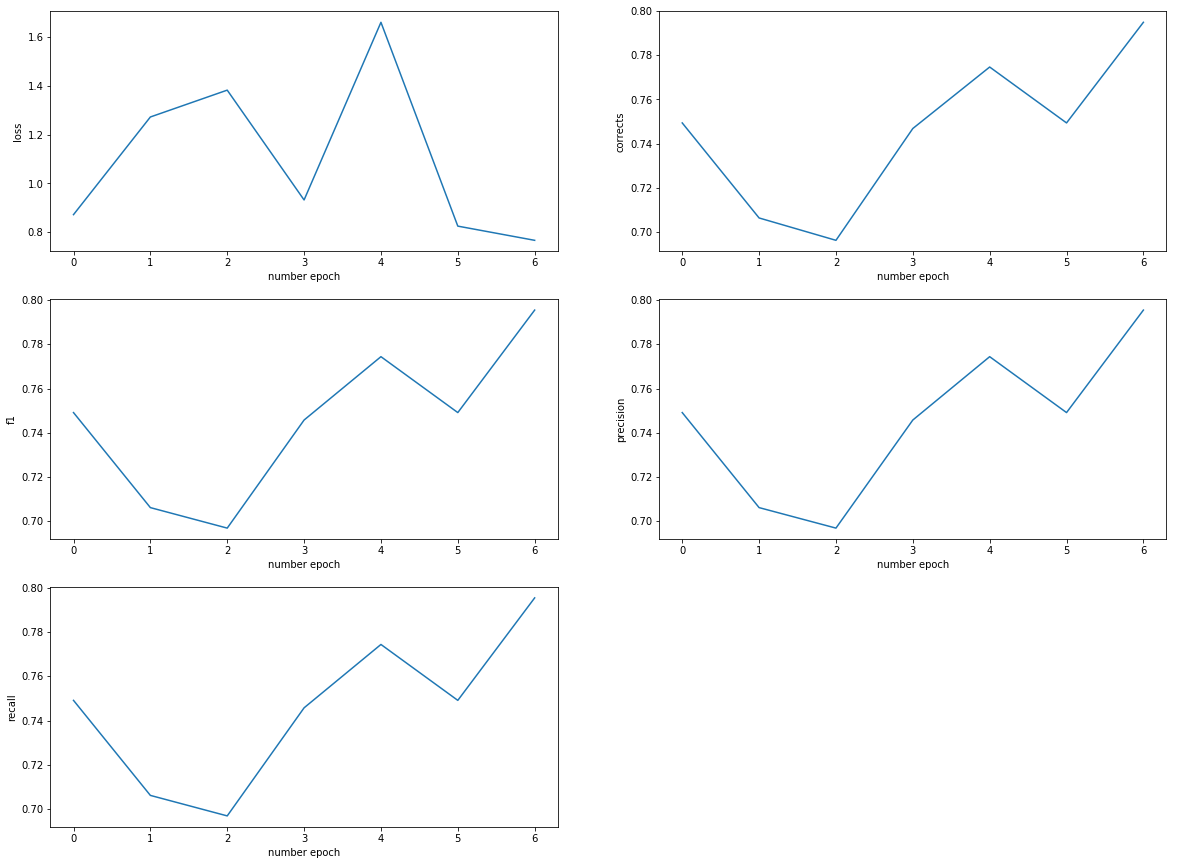

In [86]:
 model_mixed2= train_model(model_mixed2, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=7,doc_train='vgg19_mixed_train.txt',doc_valid='vgg19_mixed_valid.txt')

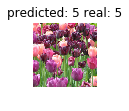

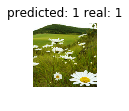

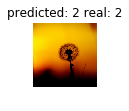

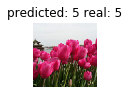

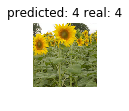

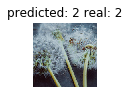

In [87]:
visualize_model(model_mixed2)

plt.ioff()
plt.show()

In [93]:
acc=evaluate(model_mixed2)

Test F1: 0.7819 Precision: 0.7819 Recall: 0.7819

Test Accuracy (Overall): 78% (294/376)
